# < Sequence to Sequnce (seq2seq) >

https://tutorials.pytorch.kr/intermediate/seq2seq_translation_tutorial.html

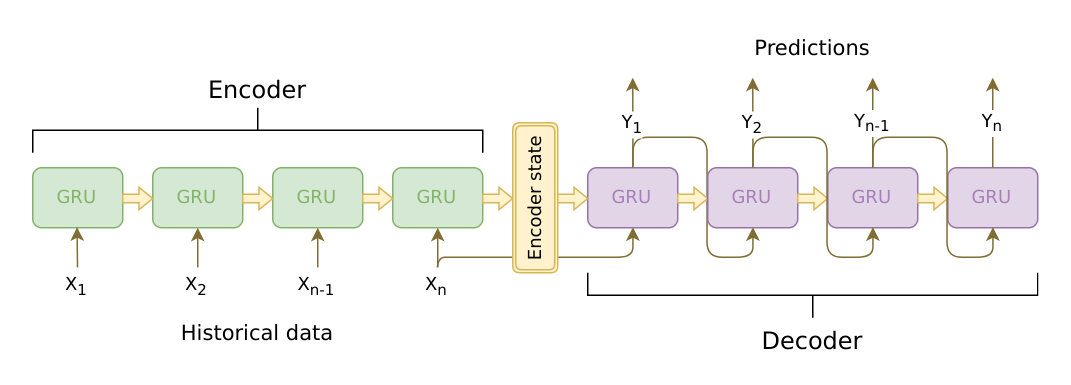

## - Import libraries

In [680]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np
%matplotlib inline


## - Set GPU Environment

In [681]:
USE_CUDA = torch.cuda.is_available()
# USE_CUDA = False
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")

## - Download English-French Dataset

In [662]:
!wget -c https://download.pytorch.org/tutorial/data.zip && unzip -o data.zip


Archive:  data.zip
  inflating: data/eng-fra.txt        
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/Italian.txt  
  inflating: data/names/Japanese.txt  
  inflating: data/names/Korean.txt   
  inflating: data/names/Polish.txt   
  inflating: data/names/Portuguese.txt  
  inflating: data/names/Russian.txt  
  inflating: data/names/Scottish.txt  
  inflating: data/names/Spanish.txt  
  inflating: data/names/Vietnamese.txt  


--2023-02-10 00:14:21--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 54.230.61.128, 54.230.61.24, 54.230.61.3, ...
Connecting to download.pytorch.org (download.pytorch.org)|54.230.61.128|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



## - Prepare the Dataset

### - Make Lang Class - Helper for word2idx and idx2word
  

In [682]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # SOS 와 EOS 포함

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1


### - Pre-processing

In [683]:
# 유니 코드 문자열을 일반 ASCII로 변환하십시오.
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# 소문자, 다듬기, 그리고 문자가 아닌 문자 제거


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s


### - Prepare the French-English Pair Dataset

In [684]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # 파일을 읽고 줄로 분리
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # 모든 줄을 쌍으로 분리하고 정규화
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # 쌍을 뒤집고, Lang 인스턴스 생성 (for F -> En)
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs


### - Filtering by MAX_LENGTH and Apply Prefixes

In [685]:
MAX_LENGTH = 6     # 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]


### - Do it!

In [687]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print()
for i in range(10):
    print(random.choice(pairs))


Reading lines...
Read 135842 sentence pairs
Trimmed to 3328 sentence pairs
Counting words...
Counted words:
fra 1771
eng 973

['nous sommes vraiment bons .', 'we re really good .']
['je suis fou .', 'i m crazy .']
['ce sont des bebes .', 'they re babies .']
['je suis un artiste .', 'i am an artist .']
['ils sont miens .', 'they re mine .']
['nous en avons fini .', 'we re through .']
['tu es mon amie .', 'you are my friend .']
['vous etes tres intelligent .', 'you re very intelligent .']
['il est mechant .', 'he is nasty .']
['je suis touchee .', 'i m touched .']


## - Make a Model

### - Make a EncoderRNN

In [688]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=DEVICE)


### - Make a Decoder RNN

In [689]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=DEVICE)

## - Training

### - Helpers for Sentence->Tensor 

In [670]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=DEVICE).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

### - Make Training Function for a Seq2Seq Model

In [690]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=DEVICE)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=DEVICE)

    decoder_hidden = encoder_hidden         # For the start of the decoding

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing 포함: 목표를 다음 입력으로 전달
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Teacher forcing 미포함: 자신의 예측을 다음 입력으로 사용
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # 입력으로 사용할 부분을 히스토리에서 분리

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length


### - Helpers for time of the training log

In [691]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))


### - Log Plot Maker

In [692]:
def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # 주기적인 간격에 이 locator가 tick을 설정
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)


### - Make Train Iterator

In [693]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # print_every 마다 초기화
    plot_loss_total = 0  # plot_every 마다 초기화

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)


#### - Check the Input Tensor

In [701]:
temp_iters = 4

training_pairs = [tensorsFromPair(random.choice(pairs)) for i in range(temp_iters)]          # Iteration 4

for iter in range(1, temp_iters + 1):
    training_pair = training_pairs[iter - 1]
    input_tensor = training_pair[0]
    target_tensor = training_pair[1]

    print(input_tensor.size())
    print(target_tensor.size())
    print(input_tensor, target_tensor)
    print()


torch.Size([5, 1])
torch.Size([6, 1])
tensor([[ 115],
        [  25],
        [1307],
        [   5],
        [   1]]) tensor([[ 74],
        [ 40],
        [ 42],
        [721],
        [  4],
        [  1]])

torch.Size([5, 1])
torch.Size([5, 1])
tensor([[ 27],
        [591],
        [592],
        [  5],
        [  1]]) tensor([[  2],
        [  3],
        [335],
        [  4],
        [  1]])

torch.Size([6, 1])
torch.Size([6, 1])
tensor([[114],
        [206],
        [117],
        [243],
        [  5],
        [  1]]) tensor([[125],
        [ 77],
        [267],
        [153],
        [  4],
        [  1]])

torch.Size([5, 1])
torch.Size([5, 1])
tensor([[ 114],
        [ 206],
        [1237],
        [   5],
        [   1]]) tensor([[125],
        [ 77],
        [680],
        [  4],
        [  1]])



### - Make Evaluation Function

In [694]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=DEVICE)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=DEVICE)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]


### - Make Evaluation Function for Random Sample Display

In [695]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')


### - Do It!

0m 15s (- 2m 19s) (1000 10%) 2.4803
0m 31s (- 2m 4s) (2000 20%) 1.9063
0m 46s (- 1m 47s) (3000 30%) 1.7359
1m 2s (- 1m 34s) (4000 40%) 1.6546
1m 20s (- 1m 20s) (5000 50%) 1.5383
1m 38s (- 1m 5s) (6000 60%) 1.4316
1m 55s (- 0m 49s) (7000 70%) 1.4019
2m 13s (- 0m 33s) (8000 80%) 1.2654
2m 29s (- 0m 16s) (9000 90%) 1.2087
2m 44s (- 0m 0s) (10000 100%) 1.1424


<Figure size 640x480 with 0 Axes>

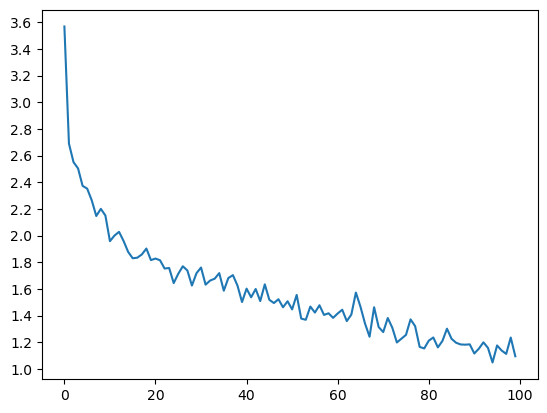

In [677]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(DEVICE)
decoder1 = DecoderRNN(hidden_size, output_lang.n_words).to(DEVICE)

# trainIters(encoder1, decoder1, 75000, print_every=5000)
trainIters(encoder1, decoder1, 10000, print_every=1000)

In [679]:
evaluateRandomly(encoder1, decoder1)

> vous etes des enfants .
= you are children .
< you are my . <EOS>

> il est vieux .
= he is old .
< he s old . <EOS>

> vous etes fort effronte .
= you re very forward .
< you re very emotional . <EOS>

> on est fauches .
= we re broke .
< we re a . . <EOS>

> je suis puissant .
= i m powerful .
< i m being . <EOS>

> je suis agriculteur .
= i m a farmer .
< i m sad . <EOS>

> je suis suffisamment forte .
= i m strong enough .
< i m being . <EOS>

> tu es tres observateur .
= you re very observant .
< you re very emotional . <EOS>

> nous sommes suffisamment proches .
= we re close enough .
< we re being . <EOS>

> tu es tres comprehensive .
= you re very understanding .
< you re very emotional . <EOS>

